# MileStone Project 2: SkimLit 📃🔥
### What Section should this sentence Belong to?

it is a Multiclass Classification problem with one to many lstm output type

where we want to label each sentence in paper abstract to which sentence it belongs to in abstract

`Objective`
`Background`
`Methods`
`Results`
`Conclusion`

## Steps we're going to cover through out this project

* Downloading a text dataset (`PubMed 200K RCT`)
* Writing a preprocessing function for our text data
* Setting up multiple modelling experiments with different levels of embeddings
* Building a multimodal model to take in different sources of data
  * Replicate the model powering https://arxiv.org/pdf/1710.06071

* Finding the most wrong prediction examples

The Model we are going to replicate is : https://arxiv.org/pdf/1612.05251

In [1]:
## Confirm acces to gpu
!nvidia-smi

Mon Jun  3 10:34:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Get data
Since we'll be replicating the ppaper above (PubMed 200k rct), let's download the dataset they used

from authors github

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 15.10 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files ar ein the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


dev is used for validation data

In [4]:
# Start our experiments using the 20k dataset with numbers replace by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [5]:
# check all the filenames in the target directory
import os

filenames = [data_dir +filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

NOw we've got some text data, it's time to become one with it

and one of the best weay to become one with data is to.. Visualize it

In [6]:
def get_lines(filename):
  """
  Reads filename (a text filename) and return the lines of text as a list

  args:
  filename: a string containing the target filepath

  return a list of string with one string per line from target filename
  """

  with open(filename, "r") as f:
    return f.readlines()


In [7]:
#let's read in the training lines

train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

How i think our data would be best represented

```
[{'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity',
    'total_lines': 11},
    ....]
    
```

In [9]:
def preprocess_txt_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contencts and sortes through each line,
  extracting things link the target label, the text of the sentence,
  how many sentence are in the current abstract and what sentence number the target line is

  """

  input_lines = get_lines(filename)
  abstract_lines = "" # Create an empty abstract
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = "" # Reset the abstract string if the line is id lines
    elif line.isspace(): # if line is a new line
      abstract_line_split = abstract_lines.splitlines()

      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else: # if the above conditions aren't fulfielled , the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
%%time

train_samples = preprocess_txt_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_txt_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_txt_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 403 ms, sys: 104 ms, total: 508 ms
Wall time: 506 ms


In [11]:
# check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [13]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [14]:
val_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


In [15]:
# Distribution of   labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

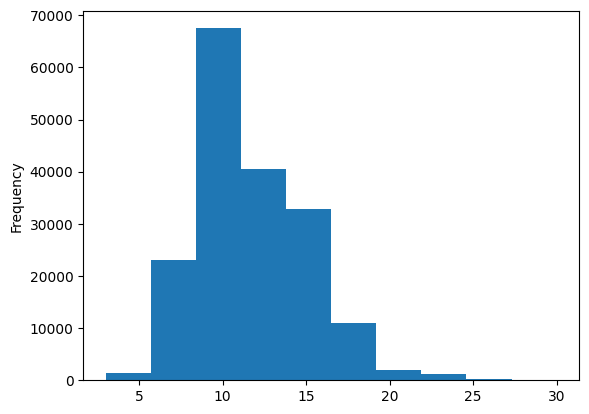

In [16]:
# Let's check the lenght of different lines
train_df.total_lines.plot.hist();

In [17]:
### Get lists of sentences

train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

list(map(len, [train_sentences, val_sentences, test_sentences]))

[180040, 30212, 30135]

## Make numeric labels (ML models)



In [18]:
train_df['target']

0           OBJECTIVE
1             METHODS
2             METHODS
3             METHODS
4             METHODS
             ...     
180035        RESULTS
180036        RESULTS
180037        RESULTS
180038    CONCLUSIONS
180039    CONCLUSIONS
Name: target, Length: 180040, dtype: object

In [19]:
train_df['target'].to_numpy().reshape(-1, 1)[:10]

array([['OBJECTIVE'],
       ['METHODS'],
       ['METHODS'],
       ['METHODS'],
       ['METHODS'],
       ['METHODS'],
       ['RESULTS'],
       ['RESULTS'],
       ['RESULTS'],
       ['RESULTS']], dtype=object)

In [20]:
# one hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))


 #check what one hot encoded labels look slike
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [21]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

#check what training labels looks like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## List of experiments we're going to run

We can start with one of the simplest examples of a table:

0. Naive Bayes with TF-IDF encoder (baseline)
1. Conv1D with token embedding
2. Tensorflow Hub Pretrained feature Extractor
3. Conv1D with character embeddings
4. Pretrained token embedding(same as 2) + character embedding(same as 3)
5. Pretrained toekn embedding + character embedding + positional embeddings

## Model 0: Getting Baseline

In [23]:
# TF-IDF Multinormail Naive Bayes

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer


model_0 = Pipeline([
    ("TfidfVectorizer", TfidfVectorizer()),
    ("MultinomialNB", MultinomialNB())
])

# fit the pipeline

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                ('MultinomialNB', MultinomialNB())])

In [24]:
# Evaluate baseline model on validation dataset

model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [25]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [26]:
### Download the helperfunction script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import calculate_results

--2024-06-03 10:34:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-06-03 10:34:50 (10.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [27]:
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_preds)

In [28]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1: Conv1d with Tokenembedding

## preparing our data for deep sequence models

create vectorization and embedding layers

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
# How long is each sentence on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

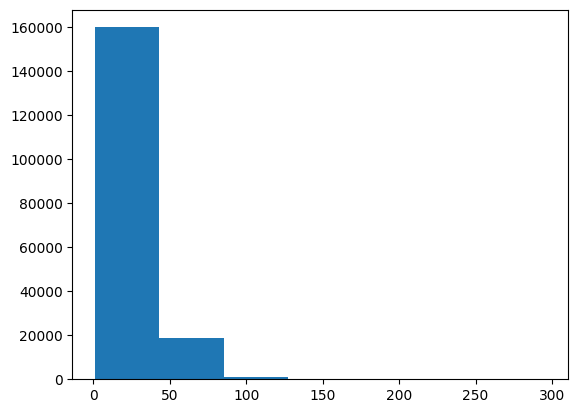

In [31]:
# what's the distribution looks like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins  = 7);

In [32]:
# let's check percentile to see what lenght covers 95% of data
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [33]:
# Maximum sequence len
max(sent_lens)

296

### Create text vectorizer layer

we want to make a layer which maps our text from words to numbers

In [34]:
from tensorflow.keras.layers import TextVectorization, Embedding

max_tokens = 68000 # as in RCT 20k paper
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_mode= 'int',
                                    output_sequence_length = output_seq_len)


In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random

target_sentence = random.choice(train_sentences)
print(f"Text: \n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text: 
nim was administered in a dose of @ gperm ( @ ) , @min before the first daily rt fraction .

Length of text: 21

Vectorized text: [[22427    10   336     5     8   131     4 56868   242   129     2   152
    161  1095  1015     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [37]:
# How many words in our training vocaburlary

rct_20K_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20K_text_vocab)}")

print(f"Most common words in the vocab: {rct_20K_text_vocab[:5]}")

print(f"Least common words in the vocab: {rct_20K_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [39]:
token_embed = Embedding(input_dim = len(rct_20K_text_vocab),
                        output_dim = 128, # Note different embedding sizes result in drastically different numbers of parameters to train,
                        mask_zero = True,
                        name = 'token_embedding')

In [40]:
print(f"Senteces before vectorization: \n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding): \n{vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence}")

Senteces before vectorization: 
nim was administered in a dose of @ gperm ( @ ) , @min before the first daily rt fraction .

Sentence after vectorization (before embedding): 
[[22427    10   336     5     8   131     4 56868   242   129     2   152
    161  1095  1015     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding: 
 [[[-0.01493146 -0.01621132  0.01980675 ... -0.0464428   0.0285136
   -0.03858292]
  [-0.01014385 -0.04861604  0.00566407 ... -0.01783776 -0.03783002
   -0.00980095]
  [ 0.04627052  0.01174963  0.04181031 ... -0.00929533  0.01607909
   -0.03076606]
  ...
  [ 0.01231378 -0.01311459 -0.03841227 ... -0.01235928 -0.03513598
    0.02812389]
  [ 0.01231378 -0.01311459 -0.03841227 ... -0.01235928 -0.03513598
    0.02812389]
  [ 0.01231378 -0.01311459 -0.03841

In [41]:
embedded_sentence.shape

TensorShape([1, 55, 128])

### Create datasets (making sure our data loads as fast as possible)

we're going to setup our data to run as fast as possible with the tensorflow tf.data API

In [42]:
# Turn our data into Tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
# taken the tensorSliceDataset's and turn then into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embedding

In [44]:
inputs = layers.Input(shape = (1, ), dtype = tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, kernel_size = 5,padding = 'same', activation = 'relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs , outputs)

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [45]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1* len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)),
                              epochs = 5)

Epoch 1/5
562/562 [==============================] - 21s 31ms/step - loss: 0.9161 - accuracy: 0.6380 - val_loss: 0.6796 - val_accuracy: 0.7443
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6576 - accuracy: 0.7544 - val_loss: 0.6296 - val_accuracy: 0.7683
Epoch 3/5
562/562 [==============================] - 5s 8ms/step - loss: 0.6205 - accuracy: 0.7749 - val_loss: 0.5979 - val_accuracy: 0.7849
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5910 - accuracy: 0.7891 - val_loss: 0.5784 - val_accuracy: 0.7902
Epoch 5/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5910 - accuracy: 0.7921 - val_loss: 0.5629 - val_accuracy: 0.7972


In [46]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [47]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_preds = tf.squeeze(tf.argmax(model_1_pred_probs, axis = 1))
model_1_preds

945/945 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [48]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 80.14365152919369,
 'precision': 0.8020481036824703,
 'recall': 0.8014365152919369,
 'f1': 0.7981196003679175}

In [49]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embedding

NOw lets use pretrained word embedding from TensorFlow Hub, more specifically the universal sentence encoder

In [50]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")

In [51]:
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence: \n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding: \n{use_embedded_sentence}")


Random Sentence: 
individuals in this group maintained approximately @ % lower weight than baseline compared with those in the diet+ex group whom maintained approximately @ % lower weight than baseline .
Sentence after embedding: 
[[-0.04870665  0.05367165 -0.06306585 -0.06151378 -0.0578799  -0.01716086
   0.06176631 -0.01889384 -0.07333088  0.0630167   0.01145006  0.04193268
  -0.05364756  0.00178201  0.01137634  0.01668408 -0.01658354  0.05351911
  -0.06155019  0.00993227 -0.04971045 -0.0139647  -0.04835535 -0.04579081
   0.03011527  0.04377714 -0.02594204  0.00742373  0.05799249 -0.06794751
  -0.04210816 -0.05117505 -0.03019907  0.00054427  0.07098321  0.01414515
  -0.02318635  0.03571205 -0.02609451 -0.04574367  0.07217893  0.06713679
  -0.04146214 -0.04760629 -0.00167799 -0.03216892  0.05897678  0.02005787
   0.02575834 -0.04509558 -0.05133327  0.02410492  0.02223449 -0.05124629
   0.01980195 -0.01753988 -0.07528424  0.03830901  0.05836714 -0.0127787
   0.00284207 -0.04832559  0.0

In [52]:
use_embedded_sentence.shape

TensorShape([1, 512])

In [53]:
model_2 = tf.keras.Sequential([
    layers.Input(shape = [], dtype = tf.string),
    tf_hub_embedding_layer,
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes, activation = 'softmax')
])

model_2.compile(loss = 'categorical_crossentropy',
                metrics = ['accuracy'],
                optimizer = 'adam')
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [54]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)),
                              epochs = 5)

Epoch 1/5
562/562 [==============================] - 10s 14ms/step - loss: 0.9183 - accuracy: 0.6466 - val_loss: 0.7993 - val_accuracy: 0.6875
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7712 - accuracy: 0.7003 - val_loss: 0.7582 - val_accuracy: 0.7051
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7548 - accuracy: 0.7105 - val_loss: 0.7419 - val_accuracy: 0.7128
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7209 - accuracy: 0.7219 - val_loss: 0.7134 - val_accuracy: 0.7251
Epoch 5/5
562/562 [==============================] - 6s 11ms/step - loss: 0.7284 - accuracy: 0.7194 - val_loss: 0.6914 - val_accuracy: 0.7357


In [55]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.6998 - accuracy: 0.7334


[0.6998129487037659, 0.7333509922027588]

In [56]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_preds =  tf.argmax(model_2_pred_probs, axis = 1)
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results


945/945 [==============================] - 10s 10ms/step


{'accuracy': 73.33509863630346,
 'precision': 0.7301279179009782,
 'recall': 0.7333509863630345,
 'f1': 0.7277343328789639}

In [57]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D character embeddings



## Create a character-level tokenizer

In [58]:
list(train_sentences[0])[:10]

['t', 'o', ' ', 'i', 'n', 'v', 'e', 's', 't', 'i']

In [59]:
" ".join(list(train_sentences[0])[:10])

't o   i n v e s t i'

In [60]:
def split_chars(text):
  return " ".join(list(text))

# Text spliting non-character-level sequence into characters
split_chars(random_train_sentence)

'i n d i v i d u a l s   i n   t h i s   g r o u p   m a i n t a i n e d   a p p r o x i m a t e l y   @   %   l o w e r   w e i g h t   t h a n   b a s e l i n e   c o m p a r e d   w i t h   t h o s e   i n   t h e   d i e t + e x   g r o u p   w h o m   m a i n t a i n e d   a p p r o x i m a t e l y   @   %   l o w e r   w e i g h t   t h a n   b a s e l i n e   .'

In [61]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [62]:
char_lens = [len(sentences) for sentences in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

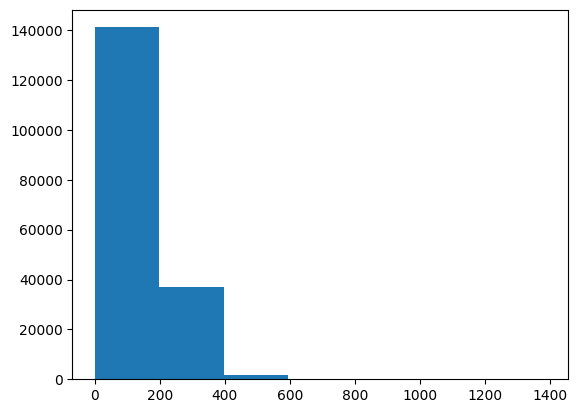

In [63]:
# check the Distribution of sentences
plt.hist(char_lens, bins = 7);

In [64]:
# find what character lenght covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

#### what is character level vocabulary
It is not same as 68K for token level since characters can be repeated very more frequenctly so what can we use.




In [65]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
len(alphabet) # this can be character level vocabulary

68

In [67]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token

char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    standardize = 'lower_and_strip_punctuation', # default,
                                    # standardize = None # if you want to no standardization
                                    output_sequence_length = output_seq_char_len,
                                    name = "char_vectorizer")

In [68]:
# adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [69]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [70]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)

print(f"Charified text: \n{random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectroized_chars: \n{vectorized_chars}")
print(f"\nLength of vectroized chars: {len(vectorized_chars[0])}")

Charified text: 
i d o s e @   w a s   r a t e d   w i t h   t h e   b e s t   m e a n   s c o r e   (   @   )   .
Length of random_train_chars: 38
Vectroized_chars: 
[[ 4 10  7  9  2 20  5  9  8  5  3  2 10 20  4  3 13  3 13  2 22  2  9  3
  15  2  5  6  9 11  7  8  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0

In [71]:
## Creating character level embedding

char_embed = Embedding(input_dim = len(char_vocab),
                       output_dim = 25,
                       mask_zero = True,
                       name = 'char_embed')

In [72]:
# Test out character embedding layer
print(f"Charified text: \n{random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars : \n{char_embed_example}")
print(f"Character embeddding shape : {char_embed_example.shape}")

Charified text: 
i d o s e @   w a s   r a t e d   w i t h   t h e   b e s t   m e a n   s c o r e   (   @   )   .
Embedded chars : 
[[[ 0.04844305 -0.01285348 -0.00157506 ...  0.00030807 -0.01229756
   -0.00296139]
  [-0.01101034 -0.0489687  -0.01513993 ...  0.00551771 -0.0221271
   -0.0366202 ]
  [ 0.04168073  0.0086397  -0.01539218 ...  0.00045017 -0.01534175
   -0.02043182]
  ...
  [ 0.03950656 -0.03458381 -0.0142648  ... -0.04752124  0.0169389
   -0.02759457]
  [ 0.03950656 -0.03458381 -0.0142648  ... -0.04752124  0.0169389
   -0.02759457]
  [ 0.03950656 -0.03458381 -0.0142648  ... -0.04752124  0.0169389
   -0.02759457]]]
Character embeddding shape : (1, 290, 25)


## Building a Conv1D to fit on character embeddings

In [73]:
inputs = layers.Input(shape = (1, ), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name = 'model_3_conv1d_char_embeddings')


model_3.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

### setup data loading for faster model training

In [74]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### fit the model on chars dataset

In [75]:
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)),
                              epochs = 5,
                              )

Epoch 1/5
562/562 [==============================] - 5s 8ms/step - loss: 1.2747 - accuracy: 0.4848 - val_loss: 1.0583 - val_accuracy: 0.5861
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 1.0128 - accuracy: 0.5973 - val_loss: 0.9476 - val_accuracy: 0.6257
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9302 - accuracy: 0.6359 - val_loss: 0.8636 - val_accuracy: 0.6702
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8725 - accuracy: 0.6590 - val_loss: 0.8400 - val_accuracy: 0.6818
Epoch 5/5
562/562 [==============================] - 4s 6ms/step - loss: 0.8569 - accuracy: 0.6707 - val_loss: 0.8167 - val_accuracy: 0.6842


In [76]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8387 - accuracy: 0.6771


[0.8386651873588562, 0.677148163318634]

In [77]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis =1)
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

945/945 [==============================] - 2s 2ms/step


{'accuracy': 67.71481530517676,
 'precision': 0.683297486087181,
 'recall': 0.6771481530517676,
 'f1': 0.6712833500835182}

In [78]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [79]:
model_1_results

{'accuracy': 80.14365152919369,
 'precision': 0.8020481036824703,
 'recall': 0.8014365152919369,
 'f1': 0.7981196003679175}

 ## Model 4: combining pretrained token embedding + characters embedding (hybrid model)

 1. Create a token-level embedding model (similar to `model1`)
 2. Create a character-level model (similar to  `model-3` with a slight modification)
 3. combine 1 & 2 with a concatenate (`layers.Concatenate`)
 4. Build a series of Output layers on top of 3 similar to figure 1 and section 4.2 of paper
 5. Construct a model which takes token and character level sequences as input and produces sequences label probabilities as output

In [80]:
# 1. setup token inputs/model

token_inputs  = layers.Input(shape = [], dtype = tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs, name = "Token_embed_USE")


 # 2. setup char inputs/model

char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-lstm as in figure 1
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm, name = 'char_level_bi_lstm')

# 3. Concatenate token and char inputs (create hybrid token embedding)

token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation = 'softmax')(final_dropout)

# 5. Construct model with char and token inputs

model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_and_char_embedding')

In [81]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978  

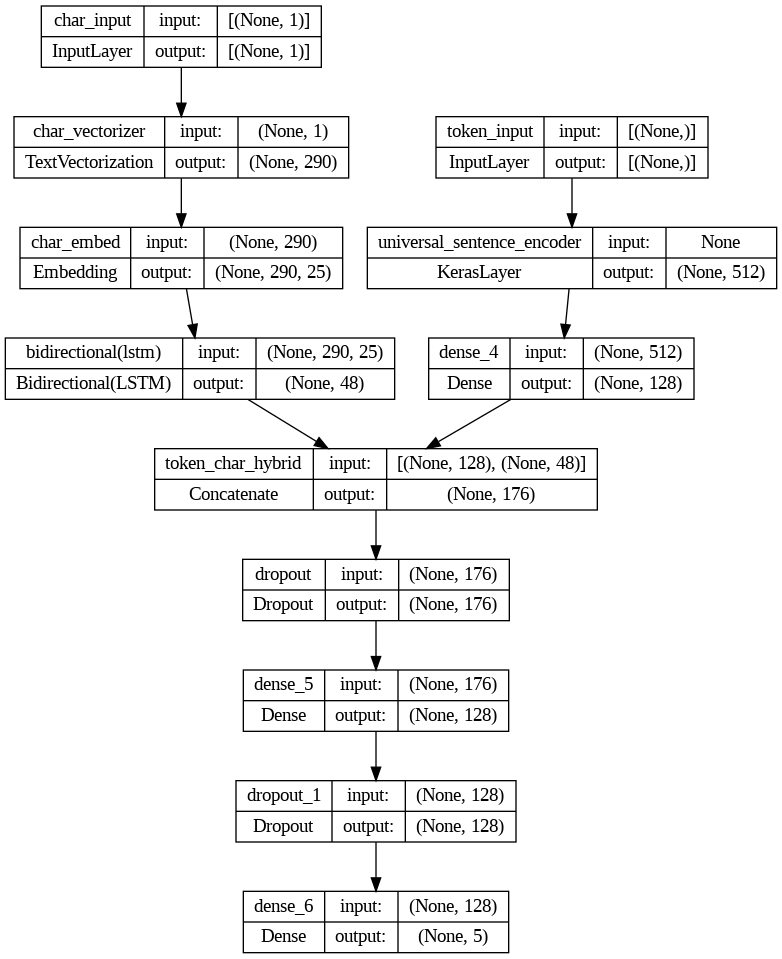

In [82]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [83]:
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])




## combining token and character data

In [84]:
# for training data
train_char_token_data  = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # this order must be same as order in which model is build
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
# combine data and labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [85]:
# for valid data
val_char_token_data  = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
# combine data and labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [86]:
# for test data
test_char_token_data  = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
# combine data and labels
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

# prefetch and batch train data
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [87]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)),
                              epochs= 5)

Epoch 1/5
562/562 [==============================] - 44s 58ms/step - loss: 0.9789 - accuracy: 0.6097 - val_loss: 0.7769 - val_accuracy: 0.6991
Epoch 2/5
562/562 [==============================] - 25s 45ms/step - loss: 0.7994 - accuracy: 0.6898 - val_loss: 0.7132 - val_accuracy: 0.7264
Epoch 3/5
562/562 [==============================] - 22s 38ms/step - loss: 0.7769 - accuracy: 0.7020 - val_loss: 0.6967 - val_accuracy: 0.7384
Epoch 4/5
562/562 [==============================] - 26s 46ms/step - loss: 0.7414 - accuracy: 0.7189 - val_loss: 0.6686 - val_accuracy: 0.7473
Epoch 5/5
562/562 [==============================] - 25s 44ms/step - loss: 0.7436 - accuracy: 0.7185 - val_loss: 0.6490 - val_accuracy: 0.7523


In [88]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 36s 38ms/step - loss: 0.6584 - accuracy: 0.7491


[0.6583573222160339, 0.7491394281387329]

In [89]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis =1 )
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

945/945 [==============================] - 38s 34ms/step


{'accuracy': 74.91394148020653,
 'precision': 0.7450449566060838,
 'recall': 0.7491394148020654,
 'f1': 0.7434375371264619}

In [90]:
model_1_results

{'accuracy': 80.14365152919369,
 'precision': 0.8020481036824703,
 'recall': 0.8014365152919369,
 'f1': 0.7981196003679175}

## Model 5: Positional embedding + Character embedding + Token embedding

In [91]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


Any engineered features used to train a model need to be available at test time

### Create positional emebeddings

In [92]:
train_df['line_number'].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

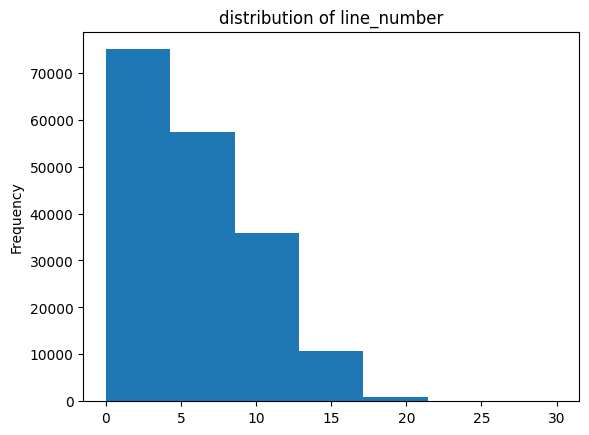

In [93]:
# check the distribution of "line_number" columns
plt.title("distribution of line_number")
train_df['line_number'].plot.hist(bins = 7);

In [94]:
# use Tensorflow to create one-hot-encoded tensors of our line_number columns
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth = 15)

train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

Now we've encoded our line numbers feature, let's do the same for our total lines features...

In [95]:
train_df['total_lines'].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

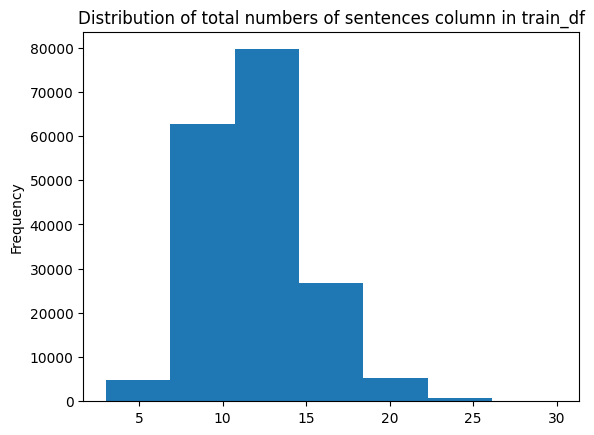

In [96]:
# plot the distribution for this
plt.title("Distribution of total numbers of sentences column in train_df")
train_df['total_lines'].plot.hist(bins = 7);

In [97]:
# check the coverage of 95% of data
np.percentile(train_df.total_lines, 95)

18.0

In [98]:
# use tensorflow to create one hot encoded samples
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth = 20)
train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

### Building a Tribrid embedding model

1. Create a token-level model
2. Create a Character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "Total_lines" features
5. combines the outputs of 1 & 2 usin tf.keras.layers.Concatenate
6. Combine the outsputs of 3, 4, 5  using tf.keras.layers.Concatenate
7. Create an outputs layer to accept of tribried embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into tf.keras.Model


In [99]:
# 1. Token inputs

token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name = 'Token_embedding_USE')


# 2. Char inputs
char_inputs = layers.Input(shape = (1, ), dtype = tf.string, name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name = "char_embedding_bi_LSTM")

# 3. positional embeddings for line_numbers
line_number_inputs = layers.Input(shape = (15, ),dtype = tf.float32, name = 'line_number_inputs')
line_dense = layers.Dense(32, activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_dense, name = "positional_embed_line_numbers")

# 4. positional embeddings for total_lines
total_lines_inputs = layers.Input(shape = (20, ), dtype = tf.float32, name = "total_lines_inputs")
total_lines_dense = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_dense, name = 'positional_embed_total_lines')

# 5. combine token embeddings and char embeddings into a hybrid embeddings
combined_embeddings = layers.Concatenate(name = 'char_token_hybrid_embeddings')([token_model.output,
                                                                                 char_model.output])

z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. combine positional embedding with combined token and char embeddings

tribrid_embeddings = layers.Concatenate(name = 'char_token_positional_embeddings')([line_number_model.output,
                                                                                    total_lines_model.output,
                                                                                    z])

# 7. Create output layer
output_layer = layers.Dense(5, activation = 'softmax', name = 'output_layer')(tribrid_embeddings)

# 8. Put together mdoel with all kinds of inputs

model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = 'token_char_positional_tribrid_model')

In [100]:
model_5.summary()

Model: "token_char_positional_tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  256797

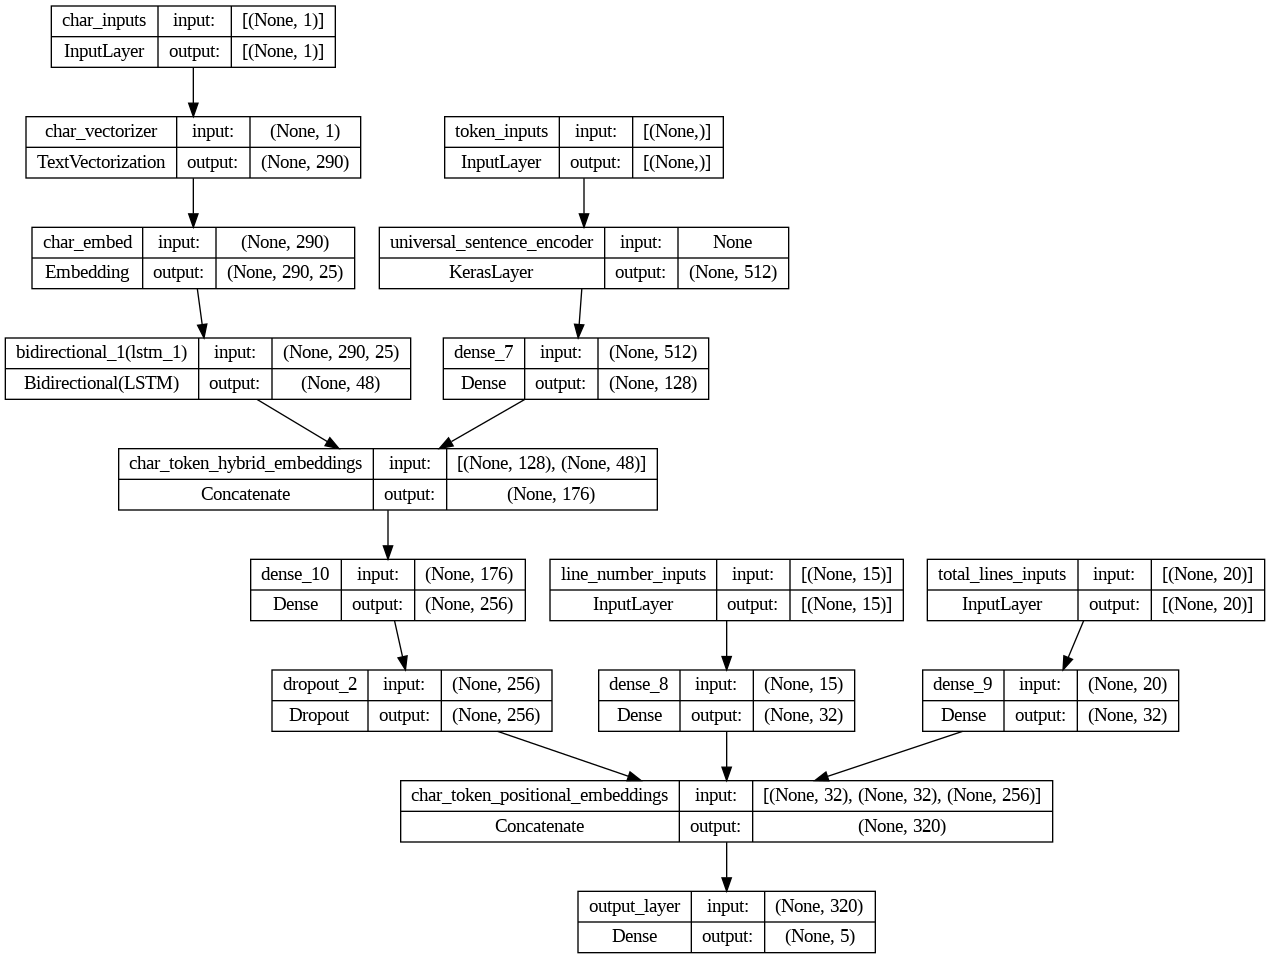

In [101]:
plot_model(model_5, show_shapes = True)

What is label smothing?

for example, if our model gets too confident on a single class (e.g. its prediction probobility is really high), it may get stuck on that class and not consider other classes...

Really confident = `[0.0, 1.0, 0.0, 0.0, 0.0]`

what label smothing does is it assign some of tha value from the highest pred prob to other classes, in turn , hopefully imporoving generallization:
`[0.01, 0.96, 0.01, 0.01, 0.01]`

In [102]:
# compile token ,char , and positional embeddings model

model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), # helps to prevent overfitting
                optimizer = 'adam',
                metrics = ['accuracy'])



### Creating dataset for model 5 (tribrid embedding mdoel)

In [107]:
# Create training and validatoin datasets (with all four kinds of inputs)

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [108]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [109]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))

test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fitting, Evaluating and making predictions with our tribrid model

In [110]:
# fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset) ),
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1 * len(val_char_token_pos_dataset)),
                              epochs = 5)

Epoch 1/5
562/562 [==============================] - 40s 50ms/step - loss: 1.1026 - accuracy: 0.7240 - val_loss: 0.9838 - val_accuracy: 0.8055
Epoch 2/5
562/562 [==============================] - 41s 74ms/step - loss: 0.9689 - accuracy: 0.8144 - val_loss: 0.9521 - val_accuracy: 0.8241
Epoch 3/5
562/562 [==============================] - 33s 59ms/step - loss: 0.9510 - accuracy: 0.8224 - val_loss: 0.9406 - val_accuracy: 0.8301
Epoch 4/5
562/562 [==============================] - 38s 68ms/step - loss: 0.9395 - accuracy: 0.8344 - val_loss: 0.9287 - val_accuracy: 0.8348
Epoch 5/5
562/562 [==============================] - 37s 66ms/step - loss: 0.9364 - accuracy: 0.8365 - val_loss: 0.9241 - val_accuracy: 0.8388


In [111]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 35s 37ms/step - loss: 0.9214 - accuracy: 0.8425


[0.921448290348053, 0.8425459861755371]

In [114]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_results = calculate_results(val_labels_encoded, model_5_preds)

945/945 [==============================] - 23s 18ms/step


In [115]:
model_5_results

{'accuracy': 84.25460082086587,
 'precision': 0.8458457840352168,
 'recall': 0.8425460082086588,
 'f1': 0.8385625394685003}

## Compare Model results

In [117]:
# combine Model results into a dataframe

all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results['accuracy']/=100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.801437,0.802048,0.801437,0.798120
model_2_pretrained_token_embedding,0.733351,0.730128,0.733351,0.727734
model_3_char_embedding,0.677148,0.683297,0.677148,0.671283
model_4_hybrid_char_token_embedding,0.749139,0.745045,0.749139,0.743438
model_5_pos_char_token_embedding,0.842546,0.845846,0.842546,0.838563


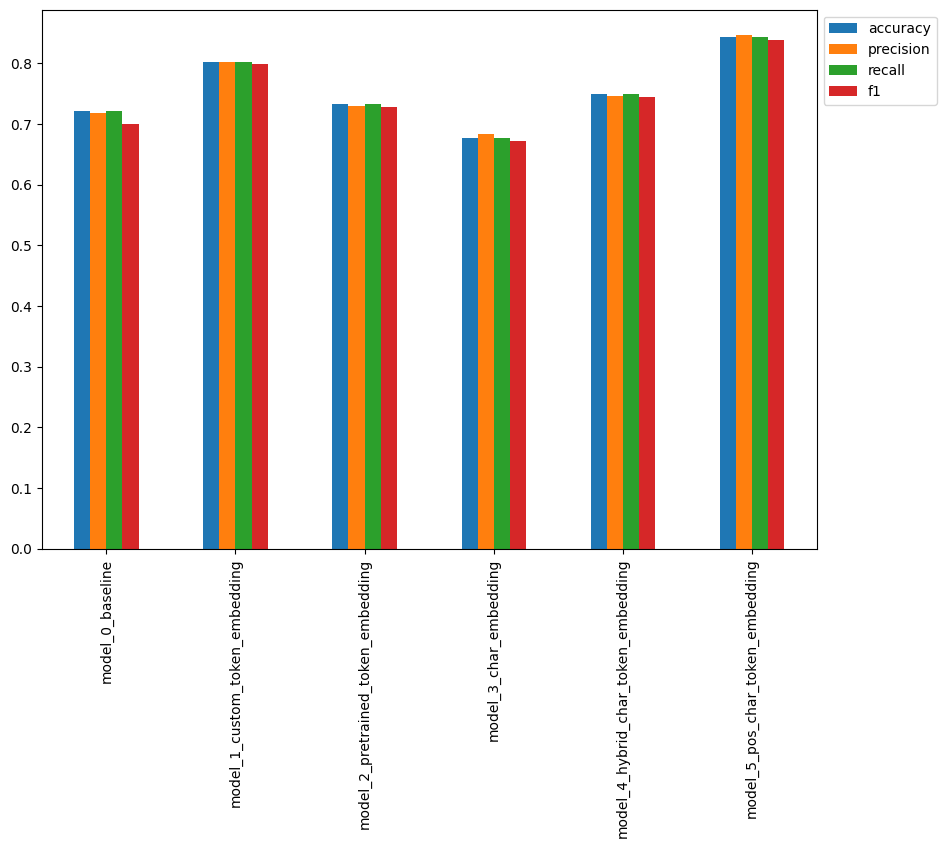

In [118]:
all_model_results.plot(kind = 'bar', figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

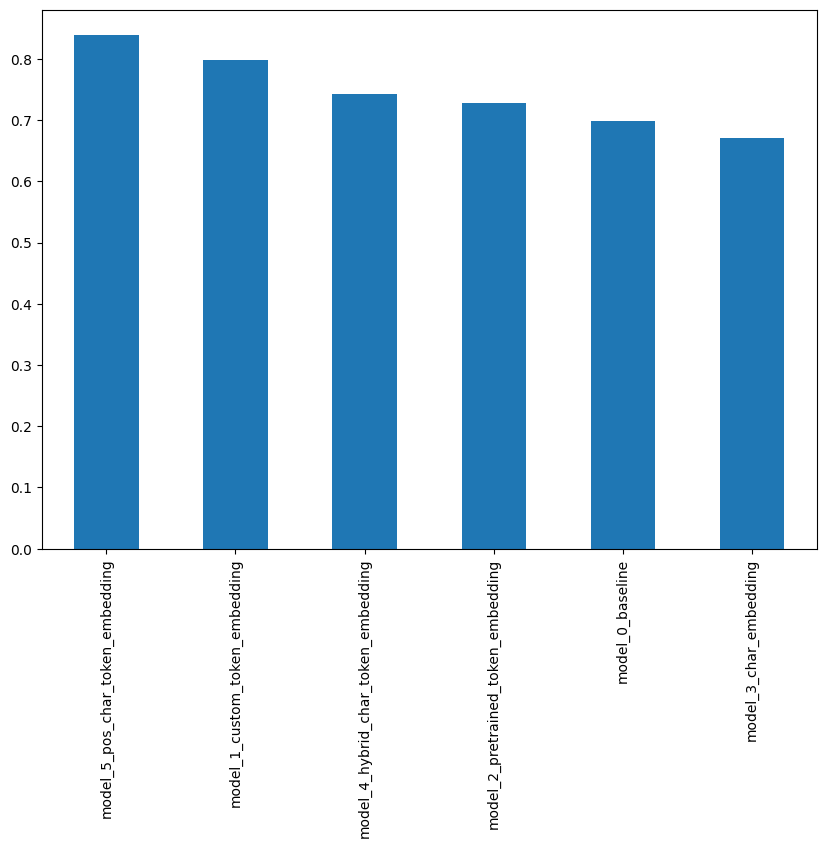

In [119]:
# sort model results by f1-score

all_model_results.sort_values('f1', ascending = False)['f1'].plot(kind = 'bar', figsize = (10, 7));

## Save and load model

In [120]:
model_5.save("skimlit_tribrid_model")

In [121]:
#load the model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")


In [123]:
loaded_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 25s 20ms/step - loss: 0.9214 - accuracy: 0.8425


[0.921448290348053, 0.8425459861755371]

In [124]:
model_5_results

{'accuracy': 84.25460082086587,
 'precision': 0.8458457840352168,
 'recall': 0.8425460082086588,
 'f1': 0.8385625394685003}

In [125]:
loaded_model.summary()

Model: "token_char_positional_tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  256797

In [126]:
# Download the pretrained model from google stroge
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-06-03 11:13:38--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.207, 142.250.157.207, 142.251.8.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  22.2MB/s    in 43s     

2024-06-03 11:14:22 (21.4 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/sk

In [127]:

# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding


## Make predictions and Evaluate them against the truth labels

In [130]:
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]



945/945 [==============================] - 27s 25ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [131]:
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.03323182841254,
 'precision': 0.8290556618130785,
 'recall': 0.8303323182841255,
 'f1': 0.8294263092000485}

In [132]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)


array([False, False, False, False])

## Evaluate model on test dataset

In [134]:
test_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [136]:
test_pred_probs = loaded_model.predict(test_char_token_pos_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 23s 24ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [137]:

# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.57176041148166,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

## Find most wrongs

In [139]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:20]

CPU times: user 17.5 s, sys: 727 ms, total: 18.3 s
Wall time: 23.6 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS']

In [140]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.523885,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.351917,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.802459,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652782,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.665070,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.881815,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.529839,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.568003,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.461431,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.537819,True


In [141]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.946719,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.934974,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.930986,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.928262,False
10452,BACKGROUND,to validate the association between accommodat...,0,10,OBJECTIVE,0.918880,False
...,...,...,...,...,...,...,...
12134,RESULTS,we conducted a population-based case-control s...,2,16,METHODS,0.840899,False
2605,RESULTS,"circulating epc ( cells positive for cd@ , cd@...",4,10,METHODS,0.840442,False
19223,METHODS,"of the @ dogs receiving placebo , @ ( @ % ) vo...",7,10,RESULTS,0.840310,False
20003,CONCLUSIONS,most subjects with bronchospasm responded to r...,9,11,RESULTS,0.839986,False


In [142]:

# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")


Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9467191696166992, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9349740743637085, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9309859275817871, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9282616972923279, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.918879508972168, Line number: 0, Total lines: 10

Text:
to validate the association between accommodation and visual asthenopia by measuring objective accommodative amplitude with the optical quality analysis system ( oqas , visiometrics , terrassa , spain ) 

## Make example predictions

In [144]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-06-03 11:19:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-06-03 11:19:25 (65.0 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [145]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [146]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [147]:

# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [149]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [150]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [151]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [152]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step
CPU times: user 1.85 s, sys: 11.5 ms, total: 1.87 s
Wall time: 2.06 s


array([[0.2644824 , 0.1105424 , 0.01762423, 0.5750657 , 0.03228523],
       [0.06927066, 0.03808296, 0.7078093 , 0.09543166, 0.08940545],
       [0.13772687, 0.04937517, 0.5467969 , 0.1634129 , 0.10268808],
       [0.09659057, 0.1711164 , 0.52574384, 0.07601642, 0.13053273],
       [0.04459698, 0.08888115, 0.4567545 , 0.04623032, 0.36353707],
       [0.03265214, 0.14626428, 0.517485  , 0.04088319, 0.2627154 ],
       [0.03290156, 0.17796223, 0.07166827, 0.02870874, 0.6887592 ],
       [0.01843721, 0.13495173, 0.3208419 , 0.03389722, 0.49187192]],
      dtype=float32)

In [153]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [154]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [155]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
